### ***Libraries***

In [1]:
%pip install -qq -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import torch
import torch.optim as optim
import torchvision
import torch.nn as nn
import seaborn as sns

from torchvision.utils import save_image, make_grid
from torchvision import transforms
from PIL import Image
from diffusers import DDPMScheduler, UNet2DModel
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 113.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 107.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.2 MB/s eta 0:00:00


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Google Drive and GPU connection

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
if torch.cuda.is_available():
  print("GPU is available!")
else:
  print("GPU is not available.")

GPU is available!


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

### ***Functions***

In [5]:
def print_matrix(matrix,pattern):

    img1_np = matrix.permute(0, 2, 3, 1).detach().cpu().numpy()  # (32, 32, 32, 3)
    img2_np = pattern.detach().cpu().numpy()

    # Create a figure with subplots
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # First subplot: img1
    axs[0].imshow(img1_np[0], cmap='gray')  # Display the first image in the batch
    axs[0].set_title('Pred matrix')
    axs[0].axis('off')

    # Second subplot: img2
    axs[1].imshow(np.transpose(img2_np[0], (1, 2, 0)), cmap='gray')  # Display the first image in the batch
    axs[1].set_title('Pattern')
    axs[1].axis('off')

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()

def show_images(x):
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

def padding_zero(x):
    x = np.pad(x,((0,1),(0,1)),constant_values = 0)
    x =  np.pad(x, 4 ,constant_values = 0)
    return x

def binary_threshold(batch, threshold=0.5):

    # Apply the threshold to the batch
    binary_batch = (batch > threshold).float()

    return binary_batch


---

### ***Data loading***

Upload the data to the google drive, and change the file_path accordingly

In [ ]:
sample_data = []

for i in range(1,25001):
    file_path = f'/content/drive/MyDrive/Deep learning/Final Project/Si_MS_Scat_samp_{i}.mat'
    mat_data = sio.loadmat(file_path)

    # Extract parameters from the loaded MATLAB file
    Rm_data = np.array(mat_data['Rm']).flatten()
    Tm_data = np.array(mat_data['Tm']).flatten()
    h_data = np.tile(np.array(mat_data['h']),(32, 32)).flatten().astype(np.float32)
    xx_data = np.array(mat_data['xx']).flatten()

    # Store the parameters in a dictionary or list
    sample_dict = {
        'Sample': f'Si_MS_Scat_samp_{i}',
        'h_data': h_data,
        'xx_data': xx_data,
        'Rm_data': Rm_data,
        'Tm_data': Tm_data
    }
    sample_data.append(sample_dict)

dataset_df = pd.DataFrame(sample_data)
dataset_df.to_pickle('/content/drive/MyDrive/Deep learning/Final Project/dataset_df.pkl')

Change the path accordingly and upload the dataframe

In [6]:
path = '/content/drive/MyDrive/Deep learning/Final Project/dataset_df.pkl'
dataset_df = pd.read_pickle(path)
dataset_df.head()

,Sample,h_data,xx_data,Rm_data,Tm_data
0,Si_MS_Scat_samp_1,"[482.0, 482.0, 482.0, 482.0, 482.0, 482.0, 482...","[0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Si_MS_Scat_samp_2,"[199.0, 199.0, 199.0, 199.0, 199.0, 199.0, 199...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Si_MS_Scat_samp_3,"[295.0, 295.0, 295.0, 295.0, 295.0, 295.0, 295...","[0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Si_MS_Scat_samp_4,"[397.0, 397.0, 397.0, 397.0, 397.0, 397.0, 397...","[0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Si_MS_Scat_samp_5,"[286.0, 286.0, 286.0, 286.0, 286.0, 286.0, 286...","[0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


---

### ***Data processing***

In [7]:
sample_data = []

# h normalization
flattened_data = [value for sublist in dataset_df['h_data'] for value in sublist]
max_value = max(flattened_data)
min_value = min(flattened_data)
dataset_df['h_data'] = (dataset_df['h_data'] - min_value) / (max_value - min_value)

for i in range(0,25000):
    rm = torch.tensor(dataset_df.at[dataset_df.index[i],'Rm_data'])
    tm = torch.tensor(dataset_df.at[dataset_df.index[i],'Tm_data'])
    h = torch.tensor(dataset_df.at[dataset_df.index[i],'h_data'])
    result = np.dot(dataset_df['xx_data'][i],dataset_df['h_data'][i][0])
    result = torch.tensor(result).view(10, 10)
    xx_data = torch.tensor(dataset_df.at[dataset_df.index[i],'xx_data']).view(10, 10)

    # Assuming rm, tm, h are already defined tensors with shape (23, 23)
    rm_padding = torch.tensor(padding_zero(rm.view(23, 23)))
    tm_padding = torch.tensor(padding_zero(tm.view(23, 23)))
    xx_data_padding = torch.tensor(np.pad(xx_data, 11 ,constant_values = 0)).unsqueeze(0)
    result_padding = torch.tensor(np.pad(result, 11 ,constant_values = 0))

    # Combine the matrices into a single tensor
    combined_matrix = torch.stack([rm_padding, tm_padding, result_padding], dim=0)

    # Store the parameters in a dictionary or list
    sample_dict = {
        'sample number': f'{i}',
        'matrix': combined_matrix,
        'xx_data': xx_data_padding
    }
    sample_data.append(sample_dict)

dataset_df = pd.DataFrame(sample_data)

In [ ]:
dataset_df.head()

,sample number,matrix,xx_data
0,0,"[[[tensor(0., dtype=torch.float64), tensor(0.,...","[[[tensor(0, dtype=torch.uint8), tensor(0, dty..."
1,1,"[[[tensor(0., dtype=torch.float64), tensor(0.,...","[[[tensor(0, dtype=torch.uint8), tensor(0, dty..."
2,2,"[[[tensor(0., dtype=torch.float64), tensor(0.,...","[[[tensor(0, dtype=torch.uint8), tensor(0, dty..."
3,3,"[[[tensor(0., dtype=torch.float64), tensor(0.,...","[[[tensor(0, dtype=torch.uint8), tensor(0, dty..."
4,4,"[[[tensor(0., dtype=torch.float64), tensor(0.,...","[[[tensor(0, dtype=torch.uint8), tensor(0, dty..."


In [8]:
# Convert the 'matrix' column to a list of tensors
matrix_tensors = list(dataset_df['matrix'])

# Calculate mean and std for normalization
mean_value = torch.stack(matrix_tensors).mean(dim=(0, 2, 3))
std_value = torch.stack(matrix_tensors).std(dim=(0, 2, 3))

# Define normalization transformation
normalize = transforms.Normalize(mean=mean_value.tolist(), std=std_value.tolist())

# Apply normalization to each tensor in the 'matrix' column
for i in range(len(dataset_df)):
    matrix_tensor = dataset_df['matrix'][i]
    normalized_matrix = normalize(matrix_tensor)
    dataset_df.at[i, 'matrix'] = normalized_matrix

The light matrix:

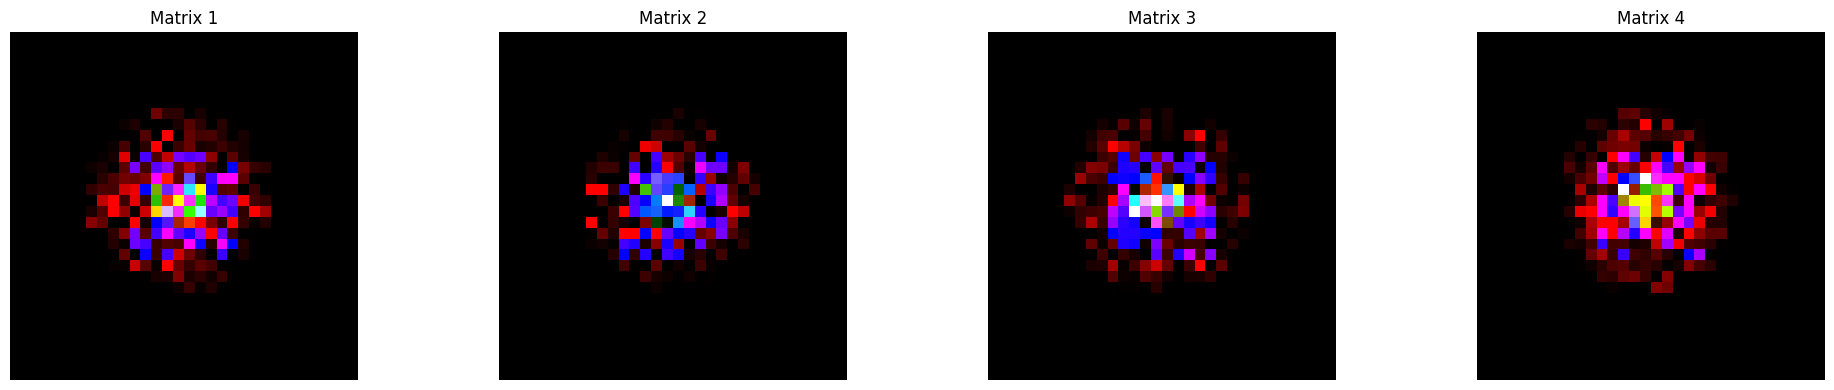

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

for i, ax in enumerate(axs):
    img = dataset_df['matrix'][i]
    img_np = img.permute(1, 2, 0).numpy()
    img_np = img_np.clip(0, 1)

    ax.imshow(img_np)
    ax.set_title('Matrix ' + str(i+1))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
dataset_df['matrix'][0].shape

torch.Size([3, 32, 32])

The pattern matrix:

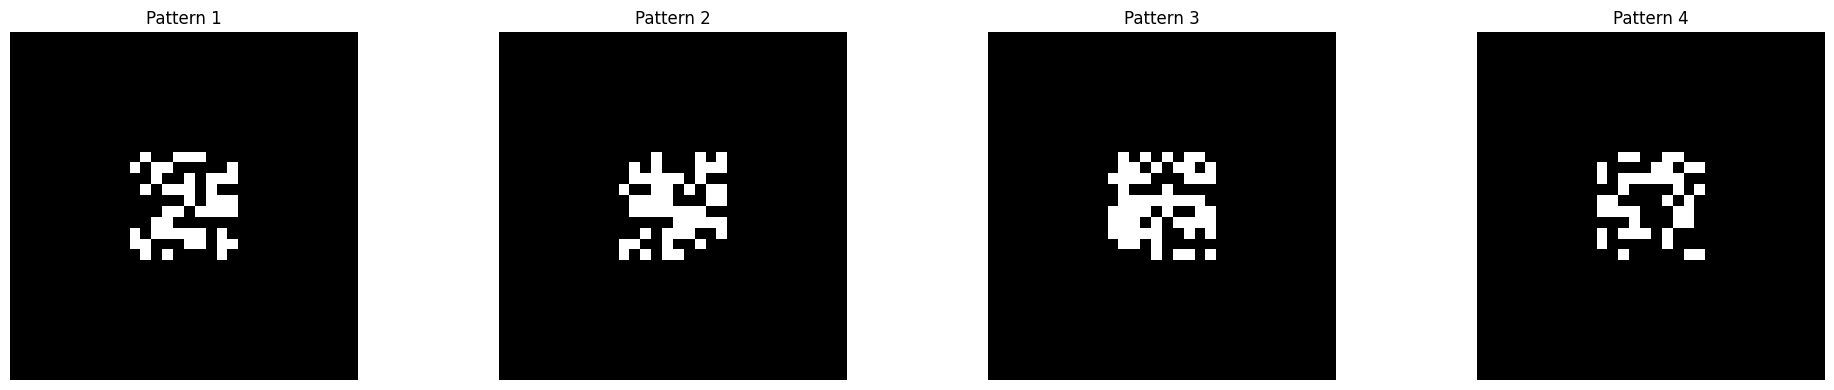

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

for i, ax in enumerate(axs):
    img = dataset_df['xx_data'][i][0]

    ax.imshow(img, cmap='gray', vmin=0, vmax=1)
    ax.set_title('Pattern '+ str(i+1))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
dataset_df['xx_data'][0].shape

torch.Size([1, 32, 32])

In [9]:
matrix = dataset_df["matrix"].tolist()  # Convert to a list of tensors
xx_data = dataset_df["xx_data"].tolist()  # Convert to a list of tensors

In [10]:
# Convert lists of tensors to PyTorch tensors
matrix = torch.stack(matrix)
xx_data = [x.view(1, 32, 32) for x in xx_data]
xx_data = torch.stack(xx_data)

Dividing the training data and test data:

In [11]:
matrix_train, matrix_test, xx_data_train, xx_data_test = train_test_split(matrix, xx_data, test_size=0.08, random_state=42)
print('matrix train shape:', matrix_train.shape)
print('xx_data train shape:', xx_data_train.shape)
print('matrix test shape:', matrix_test.shape)
print('xx_data test shape:', xx_data_test.shape)

matrix train shape: torch.Size([23000, 3, 32, 32])
xx_data train shape: torch.Size([23000, 1, 32, 32])
matrix test shape: torch.Size([2000, 3, 32, 32])
xx_data test shape: torch.Size([2000, 1, 32, 32])


In [12]:
batch_size = 20
train_dataset = TensorDataset(matrix_train.to(torch.float32),xx_data_train.to(torch.float32))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_dataset = TensorDataset(matrix_test.to(torch.float32),xx_data_test.to(torch.float32))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

X shape: torch.Size([8, 1, 32, 32])


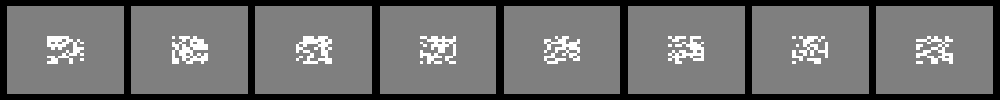

In [ ]:
xb = next(iter(train_loader))[1].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((100 * 10, 100), resample=Image.NEAREST)

---

### ***Define the Scheduler***


In [13]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

Noisy X shape torch.Size([8, 1, 32, 32])


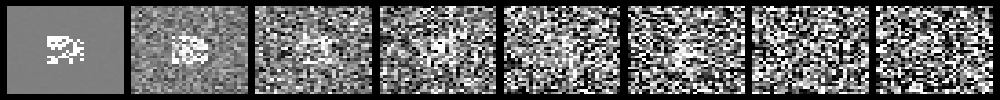

In [ ]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((100 * 10, 100), resample=Image.NEAREST)

### ***Define the Model***


In [14]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=20000, class_emb_size=3):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size= 32,           # the target image resolution
        in_channels= 1 + class_emb_size, # Additional input channels for class cond.
        out_channels= 1,           # the number of output channels
        layers_per_block= 2,       # how many ResNet layers to use per UNet block
        block_out_channels= (32 ,64 ,64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, matrix):
    # Shape of x:
    bs = 20
    ch = 3
    w = 32
    h = 32

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, matrix), 1) # (bs, 4, 32, 32)

    # Feed this to the unet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 32, 32)

### ***Create a Training Loop***
The following batches were run:
16, 20, 24, 32

In [ ]:
model = ClassConditionedUnet().to(device)

# Define the batch size and number of epochs
batch_size = 32
n_epochs = 50

# Create lists for loss functions and learning rates
loss_functions = [nn.MSELoss(), nn.L1Loss(), nn.HuberLoss()]
learning_rates = [2e-1, 1e-2, 4e-3, 3e-4]

# Initialize an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Loss Function', 'Learning Rate', 'Final Loss', 'batch size'])

# The training loop for different combinations of loss functions and learning rates
for loss_fn in loss_functions:
    for lr in learning_rates:
        # Create a new model and optimizer for each combination
        model = ClassConditionedUnet().to(device)
        opt = torch.optim.Adam(model.parameters(), lr=lr)

        # Keeping a record of the losses for later viewing
        losses = []

        # The training loop
        for epoch in range(n_epochs):
            for matrix, pattern in tqdm(train_loader):

                # Get some data and prepare the corrupted version
                matrix = matrix.to(device) * 2 - 1
                pattern = pattern.to(device)
                noise = torch.randn_like(pattern)
                timesteps = torch.randint(0, 999, (pattern.shape[0],)).long().to(device)
                noisy_step = noise_scheduler.add_noise(pattern, noise, timesteps)

                # Get the model prediction
                pred = model(noisy_step, timesteps, matrix.long())

                # Calculate the loss
                loss = loss_fn(pred, pattern)

                # Backprop and update the params:
                opt.zero_grad()
                loss.backward()
                opt.step()

                # Store the loss for later
                losses.append(loss.item())

            # Print our the average of the last 100 loss values to get an idea of progress:
            print(f'Finished epoch {epoch}')

        # Store the final loss in the DataFrame
        final_loss = losses[-1]
        results_df = results_df.append({'Loss Function': str(loss_fn), 'Learning Rate': f'{lr:.1e}', 'Final Loss': final_loss, 'batch size': 32}, ignore_index=True)

        # Print the results for the current combination
        print(f'Loss Function: {loss_fn}, Learning Rate: {lr:.1e}, Final Loss: {final_loss}')

We connected all the results to a dataframe and saved

In [ ]:
path = '/content/drive/MyDrive/Deep learning/Final Project/combined_df.pkl'
combined_df = pd.read_pickle(path)

In [ ]:
pivot_table = combined_df.pivot(index= 'Learning Rate', columns= ['batch size','Loss Function',], values='Final Loss')
pivot_table

batch size           16                              20                        \
Loss Function MSELoss()  L1Loss() HuberLoss() MSELoss()  L1Loss() HuberLoss()   
Learning Rate                                                                   
1.0e-02        0.046664  0.053940    0.023332  0.047459  0.051601    0.023732   
2.0e-01        0.047020  0.113538    0.023508  0.047689  0.062936    0.023836   
3.0e-04        0.000005  0.000303    0.000002  0.000006  0.000705    0.000003   
4.0e-03        0.000036  0.031949    0.000028  0.000060  0.005799    0.000013   

batch size           24                              32                        
Loss Function MSELoss()  L1Loss() HuberLoss() MSELoss()  L1Loss() HuberLoss()  
Learning Rate                                                                  
1.0e-02        0.046662  0.050402    0.023332  0.484380  0.052113    0.024217  
2.0e-01        0.252047  0.089244    0.023331  0.048520  0.232394    0.024259  
3.0e-04        0.000011  0.000463    0.000007  0.000005  0.000549    0.000002  
4.0e-03        0.000074  0.036567    0.000027  0.000181  0.028004    0.000063

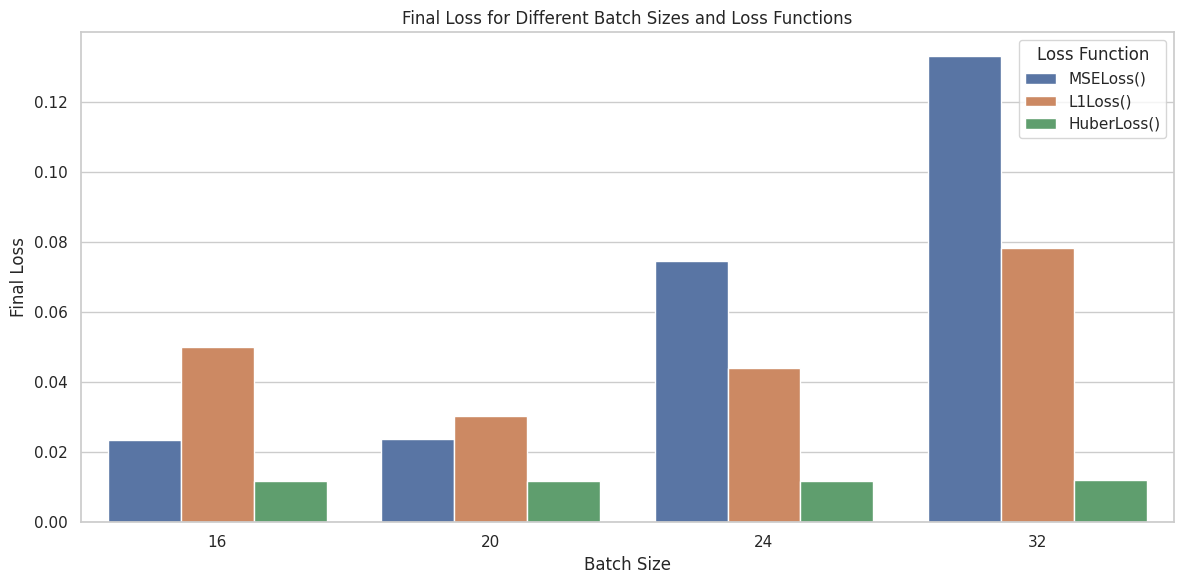

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=combined_df, x='batch size', y='Final Loss', hue='Loss Function', errorbar=None)
plt.xlabel('Batch Size')
plt.ylabel('Final Loss')
plt.title('Final Loss for Different Batch Sizes and Loss Functions')
plt.legend(title='Loss Function', loc='upper right')
plt.tight_layout()
plt.show()

As a result of the pivot table and the graph, we chose batch 20.

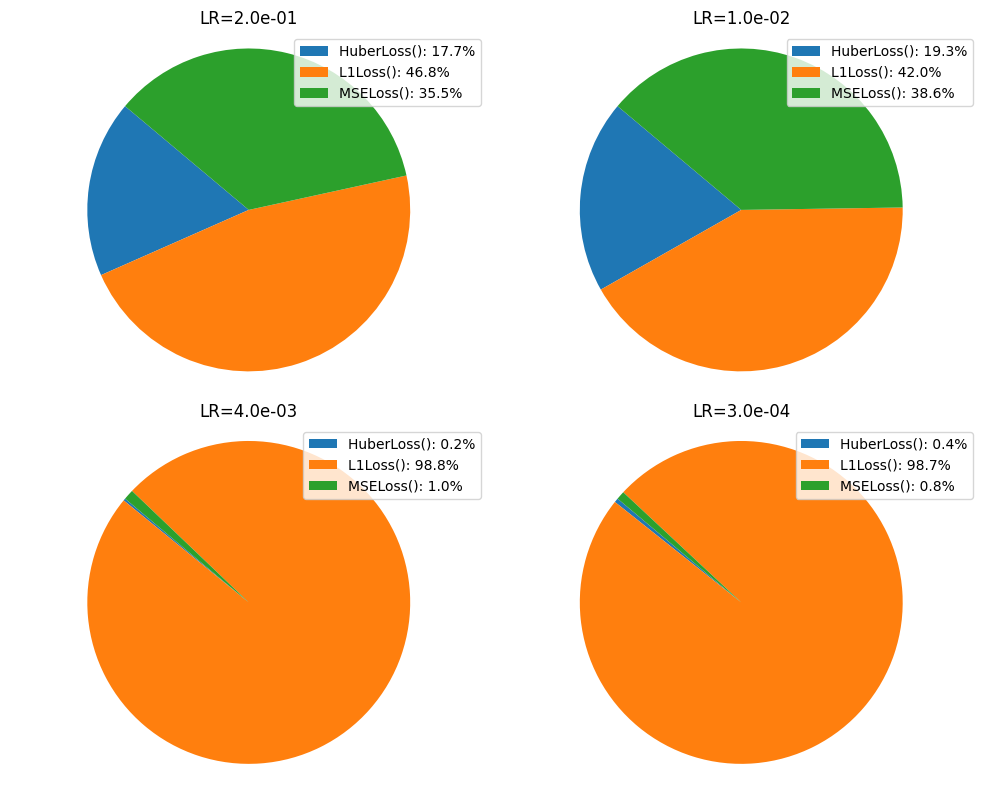

In [ ]:
# Define the learning rates you want to plot as strings
learning_rates = ['2.0e-01', '1.0e-02', '4.0e-03', '3.0e-04']

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()  # Flatten the 2x2 grid for easier indexing

# Loop through the learning rates and create a pie chart for each
for i, lr in enumerate(learning_rates):
    # Filter the DataFrame for the current learning rate
    lr_df = combined_df[(combined_df['Learning Rate'] == lr) & (combined_df['batch size'] == 20)]

    # Group the filtered DataFrame by 'Loss Function' and calculate the sum of 'Final Loss'
    grouped_df = lr_df.groupby('Loss Function')['Final Loss'].sum().reset_index()

    # Calculate percentages for the legend
    percentages = (grouped_df['Final Loss'] / grouped_df['Final Loss'].sum() * 100).round(1)

    # Plot the pie chart on the current subplot
    pie, _ = axs[i].pie(grouped_df['Final Loss'], startangle=140)
    axs[i].set_title(f'LR={lr}')
    axs[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Create a legend next to the pie chart
    legend_labels = [f'{func}: {perc}%' for func, perc in zip(grouped_df['Loss Function'], percentages)]
    axs[i].legend(pie, legend_labels, loc='upper right')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure with all four pie charts
plt.show()

As a result of the pivot table and graph, we chose the lr: 3.0e-04

---

### ***Create a training loop for batch 20***


100%|██████████| 1150/1150 [01:14<00:00, 15.43it/s]


Finished epoch 0. Average of the last 100 loss values: 0.001069


100%|██████████| 1150/1150 [01:06<00:00, 17.17it/s]


Finished epoch 1. Average of the last 100 loss values: 0.000798


100%|██████████| 1150/1150 [01:06<00:00, 17.21it/s]


Finished epoch 2. Average of the last 100 loss values: 0.000616


100%|██████████| 1150/1150 [01:05<00:00, 17.49it/s]


Finished epoch 3. Average of the last 100 loss values: 0.000496


100%|██████████| 1150/1150 [01:04<00:00, 17.71it/s]


Finished epoch 4. Average of the last 100 loss values: 0.000482


100%|██████████| 1150/1150 [01:05<00:00, 17.55it/s]


Finished epoch 5. Average of the last 100 loss values: 0.000477


100%|██████████| 1150/1150 [01:07<00:00, 17.05it/s]


Finished epoch 6. Average of the last 100 loss values: 0.000491


100%|██████████| 1150/1150 [01:06<00:00, 17.31it/s]


Finished epoch 7. Average of the last 100 loss values: 0.000451


100%|██████████| 1150/1150 [01:06<00:00, 17.29it/s]


Finished epoch 8. Average of the last 100 loss values: 0.000453


100%|██████████| 1150/1150 [01:06<00:00, 17.30it/s]


Finished epoch 9. Average of the last 100 loss values: 0.000419


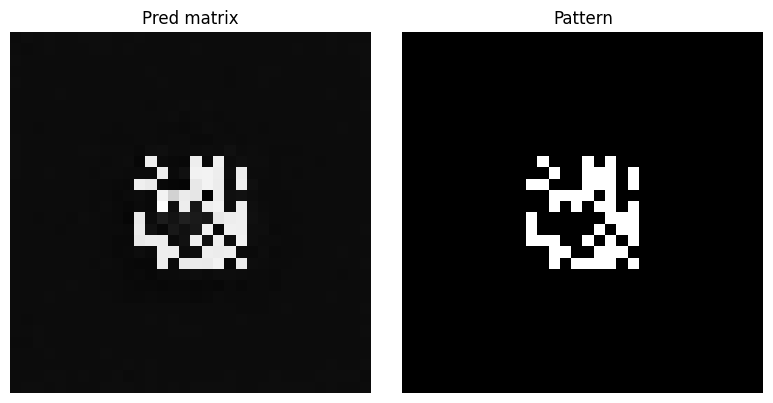

100%|██████████| 1150/1150 [01:05<00:00, 17.51it/s]


Finished epoch 10. Average of the last 100 loss values: 0.000401


100%|██████████| 1150/1150 [01:06<00:00, 17.36it/s]


Finished epoch 11. Average of the last 100 loss values: 0.000385


100%|██████████| 1150/1150 [01:06<00:00, 17.27it/s]


Finished epoch 12. Average of the last 100 loss values: 0.000463


100%|██████████| 1150/1150 [01:06<00:00, 17.33it/s]


Finished epoch 13. Average of the last 100 loss values: 0.000400


100%|██████████| 1150/1150 [01:06<00:00, 17.35it/s]


Finished epoch 14. Average of the last 100 loss values: 0.000433


100%|██████████| 1150/1150 [01:06<00:00, 17.35it/s]


Finished epoch 15. Average of the last 100 loss values: 0.000366


100%|██████████| 1150/1150 [01:05<00:00, 17.45it/s]


Finished epoch 16. Average of the last 100 loss values: 0.000397


100%|██████████| 1150/1150 [01:05<00:00, 17.52it/s]


Finished epoch 17. Average of the last 100 loss values: 0.000394


100%|██████████| 1150/1150 [01:05<00:00, 17.45it/s]


Finished epoch 18. Average of the last 100 loss values: 0.000372


100%|██████████| 1150/1150 [01:05<00:00, 17.69it/s]


Finished epoch 19. Average of the last 100 loss values: 0.000396


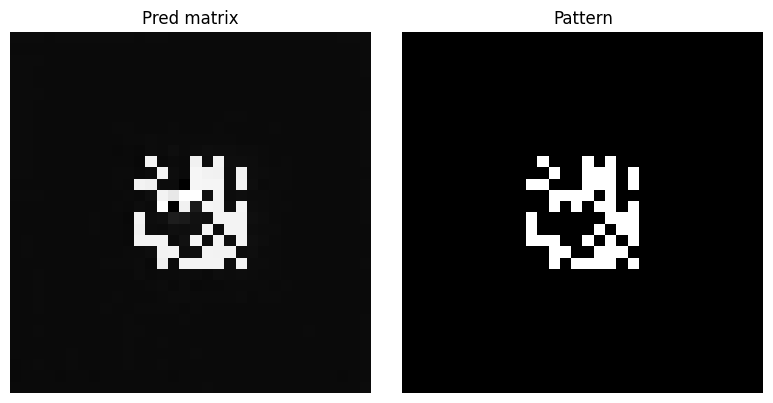

100%|██████████| 1150/1150 [01:04<00:00, 17.73it/s]


Finished epoch 20. Average of the last 100 loss values: 0.000367


100%|██████████| 1150/1150 [01:05<00:00, 17.58it/s]


Finished epoch 21. Average of the last 100 loss values: 0.000427


100%|██████████| 1150/1150 [01:05<00:00, 17.53it/s]


Finished epoch 22. Average of the last 100 loss values: 0.000382


100%|██████████| 1150/1150 [01:04<00:00, 17.79it/s]


Finished epoch 23. Average of the last 100 loss values: 0.000398


100%|██████████| 1150/1150 [01:04<00:00, 17.76it/s]


Finished epoch 24. Average of the last 100 loss values: 0.000418


100%|██████████| 1150/1150 [01:05<00:00, 17.64it/s]


Finished epoch 25. Average of the last 100 loss values: 0.000437


100%|██████████| 1150/1150 [01:05<00:00, 17.45it/s]


Finished epoch 26. Average of the last 100 loss values: 0.000370


100%|██████████| 1150/1150 [01:05<00:00, 17.67it/s]


Finished epoch 27. Average of the last 100 loss values: 0.000415


100%|██████████| 1150/1150 [01:05<00:00, 17.45it/s]


Finished epoch 28. Average of the last 100 loss values: 0.000404


100%|██████████| 1150/1150 [01:06<00:00, 17.36it/s]


Finished epoch 29. Average of the last 100 loss values: 0.000338


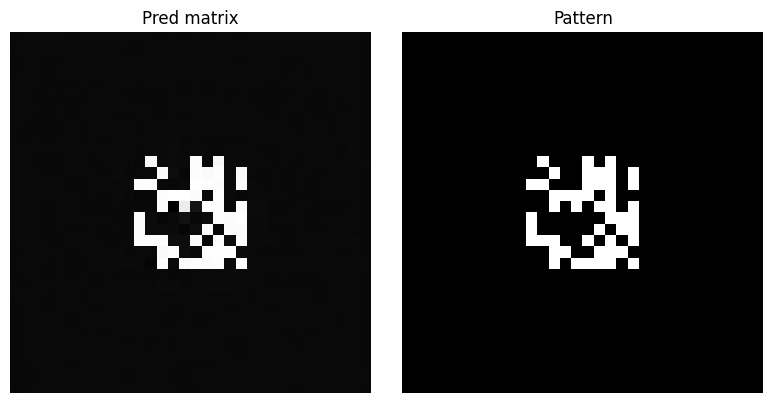

100%|██████████| 1150/1150 [01:06<00:00, 17.34it/s]


Finished epoch 30. Average of the last 100 loss values: 0.000391


100%|██████████| 1150/1150 [01:06<00:00, 17.30it/s]


Finished epoch 31. Average of the last 100 loss values: 0.000314


100%|██████████| 1150/1150 [01:05<00:00, 17.58it/s]


Finished epoch 32. Average of the last 100 loss values: 0.000404


100%|██████████| 1150/1150 [01:04<00:00, 17.72it/s]


Finished epoch 33. Average of the last 100 loss values: 0.000329


100%|██████████| 1150/1150 [01:05<00:00, 17.61it/s]


Finished epoch 34. Average of the last 100 loss values: 0.000398


100%|██████████| 1150/1150 [01:05<00:00, 17.59it/s]


Finished epoch 35. Average of the last 100 loss values: 0.000407


100%|██████████| 1150/1150 [01:05<00:00, 17.54it/s]


Finished epoch 36. Average of the last 100 loss values: 0.000371


100%|██████████| 1150/1150 [01:06<00:00, 17.26it/s]


Finished epoch 37. Average of the last 100 loss values: 0.000442


100%|██████████| 1150/1150 [01:05<00:00, 17.46it/s]


Finished epoch 38. Average of the last 100 loss values: 0.000371


100%|██████████| 1150/1150 [01:05<00:00, 17.65it/s]


Finished epoch 39. Average of the last 100 loss values: 0.000353


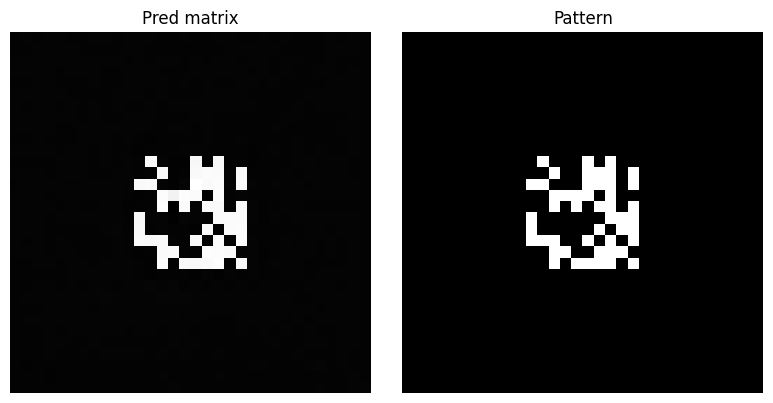

100%|██████████| 1150/1150 [01:05<00:00, 17.52it/s]


Finished epoch 40. Average of the last 100 loss values: 0.000371


100%|██████████| 1150/1150 [01:06<00:00, 17.30it/s]


Finished epoch 41. Average of the last 100 loss values: 0.000376


100%|██████████| 1150/1150 [01:05<00:00, 17.62it/s]


Finished epoch 42. Average of the last 100 loss values: 0.000374


100%|██████████| 1150/1150 [01:06<00:00, 17.36it/s]


Finished epoch 43. Average of the last 100 loss values: 0.000328


100%|██████████| 1150/1150 [01:07<00:00, 17.07it/s]


Finished epoch 44. Average of the last 100 loss values: 0.000453


100%|██████████| 1150/1150 [01:06<00:00, 17.39it/s]


Finished epoch 45. Average of the last 100 loss values: 0.000331


100%|██████████| 1150/1150 [01:05<00:00, 17.55it/s]


Finished epoch 46. Average of the last 100 loss values: 0.000373


100%|██████████| 1150/1150 [01:05<00:00, 17.57it/s]


Finished epoch 47. Average of the last 100 loss values: 0.000370


100%|██████████| 1150/1150 [01:05<00:00, 17.46it/s]


Finished epoch 48. Average of the last 100 loss values: 0.000420


100%|██████████| 1150/1150 [01:06<00:00, 17.27it/s]


Finished epoch 49. Average of the last 100 loss values: 0.000399


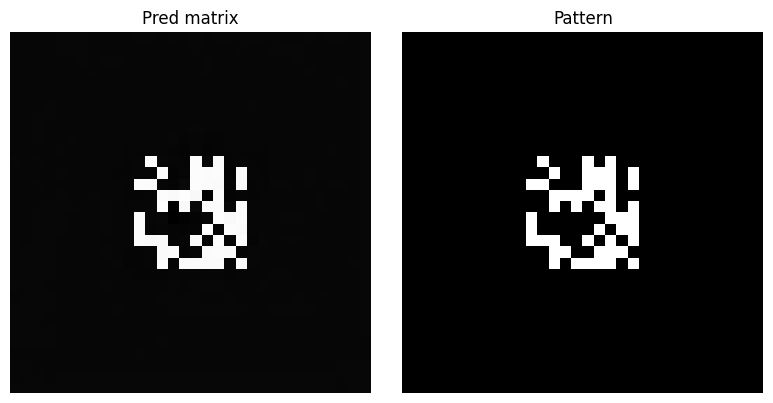

In [ ]:
batch_size = 20

n_epochs = 50

# Our network
model = ClassConditionedUnet().to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(model.parameters(), lr= 3e-4)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for matrix , pattern in tqdm(train_loader):
        # Get some data and prepare the corrupted version
        matrix = matrix.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        pattern = pattern.to(device)
        noise = torch.randn_like(pattern)
        timesteps = torch.randint(0, 999, (pattern.shape[0],)).long().to(device)
        noisy_step = noise_scheduler.add_noise(pattern, noise, timesteps)
        # Get the model prediction
        pred = model(noisy_step, timesteps, matrix.long()) # Note that we pass in the labels y
        #pred = (pred > 0.5).float()

        # Calculate the loss
        loss = loss_fn(pred, pattern) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        #loss.requires_grad = True
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')
    if ((epoch + 1) % 10 == 0):
      print_matrix(pred,pattern)

# Save the trained model after training is complete
torch.save(model.state_dict(), 'trained_model.pth')

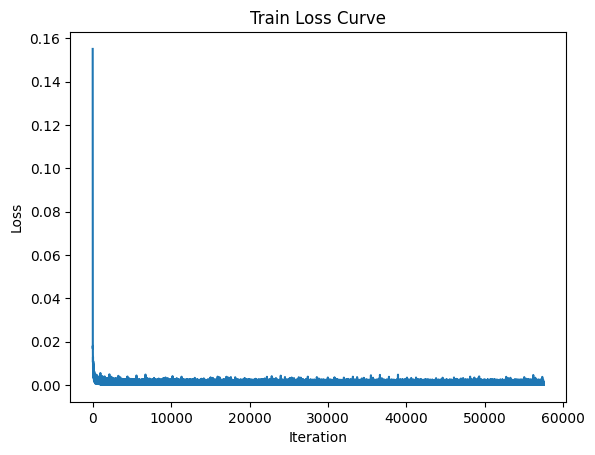

In [ ]:
# View the loss curve
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Train Loss Curve')
plt.grid(False)
plt.show()

### ***Create a test loop***

                    Type  Count
0    Correct Predictions   1972
1  Incorrect Predictions     28
Overall Image-Level Accuracy: 98.60%


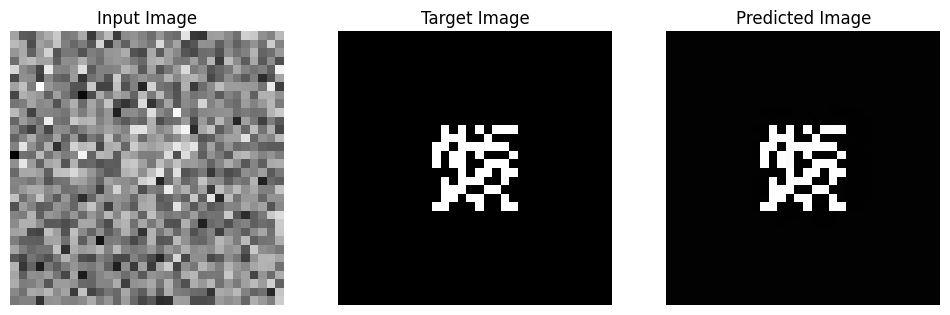

In [ ]:
# Load the trained model
model = ClassConditionedUnet().to(device)
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()  # Set the model to evaluation mode

# Initialize variables to accumulate counts
correct_predictions = 0
incorrect_predictions = 0
precisions = []
recalls = []

# Lists to store images that were correctly and incorrectly predicted
correctly_predicted_images = []
incorrectly_predicted_images = []

# Evaluation loop
with torch.no_grad():
    for matrix, pattern in test_loader:
        # Move data to the GPU if available
        matrix = matrix.to(device) * 2 - 1
        pattern = pattern.to(device)
        noise = torch.randn_like(pattern)
        timesteps = torch.randint(0, 999, (pattern.shape[0],)).long().to(device)
        noisy_step = noise_scheduler.add_noise(pattern, noise, timesteps)

        # Get model predictions
        pred = model(noisy_step, timesteps, matrix.long())
        binary_pred = binary_threshold(pred).cpu().numpy()

        # Check if each image in the batch is predicted correctly
        for i in range(binary_pred.shape[0]):
            if np.all(binary_pred[i] == pattern[i].cpu().numpy()):
                correct_predictions += 1
                correctly_predicted_images.append(pattern[i])
            else:
                incorrect_predictions += 1
                incorrectly_predicted_images.append(pattern[i])

            # Calculate precision and recall for the current image
            precision = precision_score(pattern[i].cpu().numpy().flatten(), binary_pred[i].flatten().astype(int))
            recall = recall_score(pattern[i].cpu().numpy().flatten(), binary_pred[i].flatten().astype(int))
            precisions.append(precision)
            recalls.append(recall)

# Calculate the overall image-level accuracy
total_images = correct_predictions + incorrect_predictions
image_level_accuracy = (correct_predictions / total_images) * 100
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)

# Create a summary table
summary_data = {
    'Type': ['Correct Predictions', 'Incorrect Predictions', 'Overall Image-Level Accuracy',
             'Average Precision for Individual Images', 'Average Recall for Individual Images'],
    'Count': [correct_predictions, incorrect_predictions,f'{image_level_accuracy:.2f}%',f'{average_precision:.4f}',f'{average_recall:.4f}']
}

# Display the summary table
summary_df = pd.DataFrame(summary_data)
print(summary_df)
print(f'Overall Image-Level Accuracy: {image_level_accuracy:.2f}%')

# Plot a sample of the input, target, and predicted images
sample_idx = 0  # You can change this index to visualize different samples

input_image = noisy_step[sample_idx].cpu().numpy()
target_image = pattern[sample_idx].cpu().numpy()
pred_image = pred[sample_idx].cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Display the input image in the first subplot
axs[0].imshow(input_image[0], cmap='gray')
axs[0].set_title('Input Image')
axs[0].axis('off')  # Remove ticks and labels

# Display the target image in the second subplot
axs[1].imshow(target_image[0], cmap='gray')
axs[1].set_title('Target Image')
axs[1].axis('off')  # Remove ticks and labels

# Display the predicted image in the third subplot
axs[2].imshow(pred_image[0], cmap='gray')
axs[2].set_title('Predicted Image')
axs[2].axis('off')  # Remove ticks and labels

plt.show()



In [6]:
summary_df

,Type,Count
0,Correct Predictions,1972
1,Incorrect Predictions,28
2,Overall Image-Level Accuracy,98.60%
3,Average Precision for Individual Images,0.995
4,Average Recall for Individual Images,0.995
